The purpose of this notebook is prototype the code necessary to create the streamflow historical
plot that will be displayed in the UI.

requirements: pandas, matplotlib, tqdm, dataretrieval

In [2]:
!pip install matplotlib tqdm dataretrieval -q

In [4]:
import creds
from dataretrieval import nwis
from analysis import AnalysisAssim, Offsets
from datetime import datetime,timedelta


import matplotlib.pyplot as plt
#%matplotlib ipympl

### Inputs from UI

Define a list of reaches for which data will be collected.

In [5]:
# these reaches are near Westphalia, MO (Maries river)
nwm_reach_ids = [
    '5984415',
    '5984419',
    '5984765', # this one is associated with nwis site 06927000 
    '5984441',
    '5985049',
]

# https://nwis.waterdata.usgs.gov/nwis/uv?cb_00060=on&cb_00065=on&format=gif_default&site_no=06927000&legacy=1&period=&begin_date=2024-11-01&end_date=2024-12-31

In [6]:
# The start and end times to display data
start_date = datetime(2024,10,1)
end_date   = datetime(2024,12,31)


We're using the **Analysis and Assimilation** model run to provide a glimpse of past historical conditions. This run is designed to provide the most accurate and up-to-date snapshot of current hydrologic conditions by merging model outputs with observed data. It corrects the model’s initial conditions by incorporating real-time streamflow, precipitation, and other observations. Time are used to align the data being processed with the analysis run's execution time.

The NWM Analysis and Assimilation run typically executes hourly.  Each run uses observations collected within a 6-hour window prior to the model run time. This offset allows the model to incorporate recent, quality-controlled data.
Suppose the current time is 12:00 PM, the model run will use observations collected from approximately 6:00 AM to 12:00 PM.
This time window helps correct any discrepancies from previous forecasts and enhances accuracy for short-term forecasts. Observations include data from stream gauges, radar precipitation estimates, and other environmental sensors. The offset ensures that the model accounts for reporting delays common in real-world observation networks.

To provide the most accurate historical conditions, we will use the latest offset available since this is typically the most refined since it incorporates corrected data and improved model adjustments. Since the NWM's assimilation run updates past conditions using the most complete and quality-checked observations, this version provides the most accurate representation of what conditions were truly like at that time.


In [7]:
# Analysis and Assimilation offset to use [1, 2, 3] 
offset     = 3

In [8]:
nwm_reach_ids[2]

'5984765'

In [9]:
# collect historical analysis and assimilation data
adata = AnalysisAssim(creds.key)
st = start_date.strftime('%Y-%m-%d')
et = end_date.strftime('%Y-%m-%d')
adata.collect_analysis_assim([nwm_reach_ids[2]],
                             st,
                             et,
                             offsets=[offset])
analysis_df = adata.df.copy()

# Collect NWIS Observed Streamflow
print('Collecting NWIS...', end='')
site_no = '06927000'
parameterCode = "00060" 
startDate = start_date.strftime("%Y-%m-%d")
endDate = end_date.strftime("%Y-%m-%d")
nwis_df = nwis.get_dv(sites=site_no, parameterCd=parameterCode, start=startDate, end=endDate)[0]

# NWIS 00060 is CFS. This needs to be converted to CMS for comparison with NWM
nwis_df['streamflow_cms'] = nwis_df['00060_Mean'] / (3.28**3)
print('done')


Fetching Analysis and Assimilation Data:   0%|                                                                …

In [13]:
adata.df

,feature_id,time,streamflow,velocity
0,5984765,2024-10-01 00:00:00,0.11,0.09
1,5984765,2024-10-01 01:00:00,0.11,0.09
2,5984765,2024-10-01 02:00:00,0.11,0.09
3,5984765,2024-10-01 03:00:00,0.11,0.09
4,5984765,2024-10-01 04:00:00,0.11,0.09
...,...,...,...,...
2276,5984765,2024-12-30 21:00:00,1.28,0.22
2277,5984765,2024-12-30 21:00:00,1.28,0.22
2278,5984765,2024-12-30 22:00:00,1.28,0.22
2279,5984765,2024-12-30 23:00:00,1.28,0.22


In [15]:
adata.df[['time', 'streamflow']].to_json()

'{"time":{"0":1727740800000,"1":1727744400000,"2":1727748000000,"3":1727751600000,"4":1727755200000,"5":1727758800000,"6":1727762400000,"7":1727766000000,"8":1727769600000,"9":1727773200000,"10":1727776800000,"11":1727780400000,"12":1727784000000,"13":1727787600000,"14":1727791200000,"15":1727794800000,"16":1727798400000,"17":1727802000000,"18":1727805600000,"19":1727809200000,"20":1727812800000,"21":1727816400000,"22":1727820000000,"23":1727823600000,"24":1727827200000,"25":1727830800000,"26":1727834400000,"27":1727838000000,"28":1727841600000,"29":1727845200000,"30":1727848800000,"31":1727852400000,"32":1727856000000,"33":1727859600000,"34":1727863200000,"35":1727866800000,"36":1727870400000,"37":1727874000000,"38":1727877600000,"39":1727881200000,"40":1727884800000,"41":1727888400000,"42":1727892000000,"43":1727895600000,"44":1727899200000,"45":1727902800000,"46":1727906400000,"47":1727910000000,"48":1727913600000,"49":1727917200000,"50":1727920800000,"51":1727924400000,"52":1727928

In [23]:
nwis_df

,site_no,00060_Mean,00060_Mean_cd,streamflow_cms
datetime,,,,
2024-10-01 00:00:00+00:00,06927000,2.28,A,0.064612
2024-10-02 00:00:00+00:00,06927000,2.20,A,0.062345
2024-10-03 00:00:00+00:00,06927000,1.98,A,0.056110
2024-10-04 00:00:00+00:00,06927000,1.93,A,0.054694
2024-10-05 00:00:00+00:00,06927000,1.75,A,0.049593
...,...,...,...,...
2024-12-27 00:00:00+00:00,06927000,50.60,P,1.433933
2024-12-28 00:00:00+00:00,06927000,48.20,P,1.365921
2024-12-29 00:00:00+00:00,06927000,46.30,P,1.312077


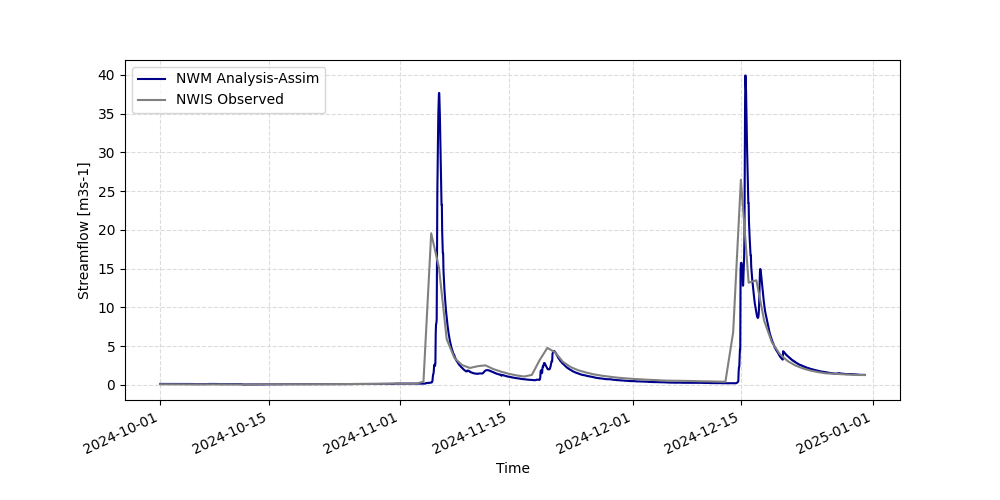

In [26]:
# Create Plots
fig, ax = plt.subplots(figsize=(10, 5))

# ANALYSIS ASSIM
analysis_df.plot(ax=ax, x='time', y='streamflow', color='darkblue', linestyle='-', label='NWM Analysis-Assim')

## NWIS
nwis_df.plot(ax=ax, y='streamflow_cms', color='grey', label='NWIS Observed')


# STYLING
ax.grid(which='both', axis='both', linestyle='--', color='gainsboro')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow [m3s-1]')
plt.xticks(rotation=25) 
plt.show()